# **Product recommendation System for E-commerce Websites**

# Importing Neccesary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
pip install surprise

     |████████████████████████████████| 11.8MB 195kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617642 sha256=782ab2ae40aaf88b543279d1a0edfba2387655b9907c7de6ece565c148e90549
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [3]:
from surprise import KNNBasic, SVD, NormalPredictor, KNNBaseline,KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering, Reader, dataset, accuracy

# Reading, visualising and Pre processing Dataset

In [4]:
columns = ['userID', 'productID', 'ratings','timestamp']

recomm_df = pd.read_csv('/content/drive/MyDrive/Project/ratings_Cell_Phones_and_Accessories.csv',names=columns)

In [5]:
recomm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447249 entries, 0 to 3447248
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userID     object 
 1   productID  object 
 2   ratings    float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 105.2+ MB


In [6]:
recomm_df.head()

,userID,productID,ratings,timestamp
0,A1EWN6KZ4HMLT7,011040047X,1.0,1344902400
1,A1YX2RBMS1L9L,0110400550,5.0,1353542400
2,A180NNPPKWCCU0,0110400550,5.0,1374105600
3,A3HVRXV0LVJN7,0110400550,5.0,1358035200
4,A292527VPX98P8,0110400550,1.0,1353888000


In [7]:
recomm_df.shape

(3447249, 4)

In [8]:
recomm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,3447249.0,3.811271e+00,1.470037e+00,1.0,3.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00
timestamp,3447249.0,1.364355e+09,4.125791e+07,942796800.0,1.355098e+09,1.374365e+09,1.391299e+09,1.406074e+09


In [9]:
recomm_df = recomm_df.drop('timestamp', axis=1)

In [10]:
recomm_df.isna().sum()

userID       0
productID    0
ratings      0
dtype: int64

In [11]:
recomm_df.shape

(3447249, 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0638d25d90>]],
      dtype=object)

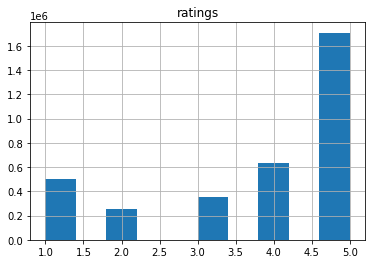

In [12]:
recomm_df.hist('ratings',bins = 10)

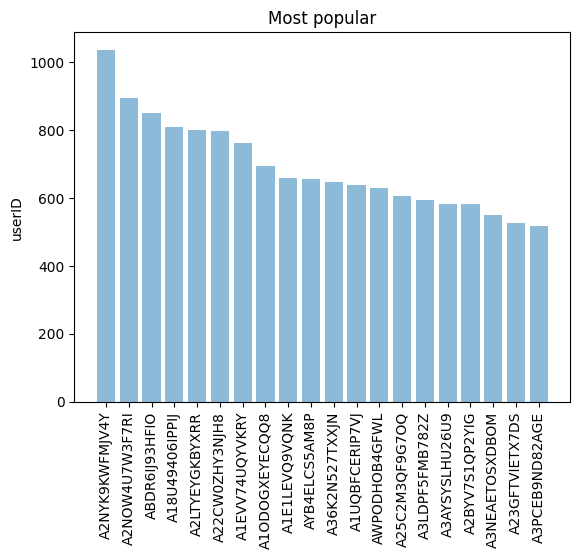

In [13]:
popular = recomm_df[['userID','ratings']].groupby('userID').sum().reset_index()
popular_20 = popular.sort_values('ratings', ascending=False).head(n=20)
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = (list(popular_20['userID']))
y_pos = np.arange(len(objects))
performance = list(popular_20['ratings'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('userID')
plt.title('Most popular')
 
plt.show()

In [14]:
# find unique users
recomm_df.userID.value_counts()

A2NYK9KWFMJV4Y    211
A2NOW4U7W3F7RI    187
A22CW0ZHY3NJH8    181
ABDR6IJ93HFIO     177
A2LTYEYGKBYXRR    169
                 ... 
A2ESWX8CNNHP36      1
ABBLFO5E2GJCA       1
A2SBH21GTETPFC      1
A3OZ8SHRYZOHPB      1
AIISBEVDEUAUN       1
Name: userID, Length: 2261045, dtype: int64

In [15]:
print('Number of unique users', len(recomm_df['userID'].unique()))

Number of unique users 2261045


In [16]:
print('Number of unique products', len(recomm_df['productID'].unique()))

Number of unique products 319678


In [17]:
print('Unique Ratings', recomm_df['ratings'].unique())

Unique Ratings [1. 5. 2. 3. 4.]


In [18]:
min_ratings1 = recomm_df[(recomm_df['ratings'] < 2.0)]

In [19]:
print('Number of unique products rated low',len(min_ratings1['productID'].unique()))

Number of unique products rated low 111747


In [20]:
med_ratings1 = recomm_df[(recomm_df['ratings'] > 2.0) & (recomm_df['ratings'] < 4.0)]

In [21]:
print('Number of unique products rated medium',len(med_ratings1['productID'].unique()))

Number of unique products rated medium 99476


In [22]:
max_ratings1 = recomm_df[recomm_df['ratings'] >= 4.0]

In [23]:
print('Number of unique products rated high',len(max_ratings1['productID'].unique()))

Number of unique products rated high 250565


In [24]:
avg_rating_prod = recomm_df.groupby('productID').sum() / recomm_df.groupby('productID').count()

In [25]:
avg_rating_prod.drop('userID', axis=1,inplace =True)

In [26]:
print ('Top 10 highly rated products \n',avg_rating_prod.nlargest(10,'ratings'))

Top 10 highly rated products 
             ratings
productID          
0214614700      5.0
0214714705      5.0
103824174X      5.0
103984068X      5.0
1049830512      5.0
1059130386      5.0
1059274930      5.0
1059359189      5.0
1059556936      5.0
1059598515      5.0


# Take a subset of the dataset to make it less sparse/ denser

In [27]:
userID = recomm_df.groupby('userID').count()

In [28]:
top_user = userID[userID['ratings'] >= 25].index

In [29]:
topuser_ratings_df = recomm_df[recomm_df['userID'].isin(top_user)]

In [30]:
topuser_ratings_df.shape

(22082, 3)

In [31]:
topuser_ratings_df.head()

,userID,productID,ratings
176,ATX7CZYFXI1KW,120401325X,5.0
326,A3R5RK752TYZ4Z,2912010594,5.0
426,A37XJZF145XH5B,549980088X,3.0
704,A2KP65JS3YY5VL,6073894996,5.0
716,ABDDX2PV61RMX,6073894996,4.0


In [32]:
topuser_ratings_df.sort_values(by='ratings', ascending=False).head()

,userID,productID,ratings
176,ATX7CZYFXI1KW,120401325X,5.0
2591884,A2GAADJ9YMV9EU,B00BD6XTDK,5.0
2593109,A1E1LEVQ9VQNK,B00BE68IYE,5.0
2593100,AN81JUYW2SL24,B00BE68IYE,5.0
2592744,ABDR6IJ93HFIO,B00BDC2ZPM,5.0


In [33]:
prodID = recomm_df.groupby('productID').count()

In [34]:
top_prod = prodID[prodID['ratings'] >= 25].index

In [35]:
top_ratings_df = topuser_ratings_df[topuser_ratings_df['productID'].isin(top_prod)]

In [36]:
top_ratings_df.sort_values(by='ratings', ascending=False).head()

,userID,productID,ratings
176,ATX7CZYFXI1KW,120401325X,5.0
1718606,ABXANRX4GPYRZ,B0089VO71U,5.0
2755828,A3TZEKXYJ9KC0M,B00CC6KX7U,5.0
1716390,AEJAGHLC675A7,B0089QBAHE,5.0
2575983,AZ5LAA4N0HUWY,B00B8P8IVO,5.0


In [37]:
top_ratings_df.shape

(14154, 3)

# Split the data randomly into train and test dataset.

In [38]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(top_ratings_df, test_size = 0.20, random_state=0)

In [39]:
train_data.head()

,userID,productID,ratings
1243572,A15QYHQH80W30L,B00634HDXE,5.0
2814266,A3SNZPUALWI73A,B00CNZJKVK,5.0
2444204,A1VAUKYQDX4H2E,B00ALE5X2U,5.0
586334,A23AHRKVZEB2EG,B0043GTIR8,5.0
2548933,A2LXX47A0KMJVX,B00B45TMTK,3.0


In [40]:
test_data.head()

,userID,productID,ratings
2855605,A2C66ZWC2V5FES,B00CXMWV1O,5.0
944285,A7C1NWHUFQ44S,B0057WXF6C,1.0
1794633,A2FKXU13USTGK0,B008DO50N2,5.0
831371,ARIDN94LOCQFD,B004W1IYOC,4.0
1163942,ARIDN94LOCQFD,B005TDWT4I,4.0


# Build Popularity Recommender model.

In [41]:
#Building the recommendations based on the average of all user ratings for each product.
train_data_grouped = train_data.groupby('productID').mean().reset_index()

In [42]:
train_data_grouped.head()

,productID,ratings
0,120401325X,5.000000
1,6073894996,3.666667
2,7532385086,5.000000
3,7887421268,5.000000
4,9983744066,5.000000


In [43]:
train_data_sort = train_data_grouped.sort_values(['ratings', 'productID'], ascending=False)

In [44]:
train_data_sort.head()

,productID,ratings
5454,B00KFY9OF8,5.0
5453,B00KFVM6JW,5.0
5450,B00KD4748Y,5.0
5449,B00KCZO2WK,5.0
5448,B00KCUIK1E,5.0


In [45]:
train_data.groupby('productID')['ratings'].count().sort_values(ascending=False).head(10)

productID
B00ANALDWQ    44
B00E2TT8W6    36
B00EZ71LM0    35
B00FAADBHO    35
B00E327OIM    31
B00G5K3B46    29
B00D64PN36    27
B0093IHVJI    24
B00BFQ9R0W    24
B00B1UQBGA    23
Name: ratings, dtype: int64

In [46]:
ratings_mean_count = pd.DataFrame(train_data.groupby('productID')['ratings'].mean())

In [47]:
ratings_mean_count['rating_counts'] = pd.DataFrame(train_data.groupby('productID')['ratings'].count())

In [48]:
ratings_mean_count.head()

,ratings,rating_counts
productID,,
120401325X,5.000000,1
6073894996,3.666667,3
7532385086,5.000000,1
7887421268,5.000000,1
9983744066,5.000000,1


In [49]:
pred_df = test_data[['userID', 'productID', 'ratings']]

In [50]:
pred_df.rename(columns = {'ratings' : 'true_ratings'}, inplace=True)

In [51]:
pred_df = pred_df.merge(train_data_sort, left_on='productID', right_on = 'productID')

In [52]:
pred_df.head(3)

,userID,productID,true_ratings,ratings
0,A7C1NWHUFQ44S,B0057WXF6C,1.0,4.166667
1,A2FKXU13USTGK0,B008DO50N2,5.0,5.000000
2,A29HN98I73AT0A,B008DO50N2,5.0,5.000000


In [53]:
pred_df.rename(columns = {'ratings' : 'predicted_ratings'}, inplace = True)

In [54]:
pred_df.head()

,userID,productID,true_ratings,predicted_ratings
0,A7C1NWHUFQ44S,B0057WXF6C,1.0,4.166667
1,A2FKXU13USTGK0,B008DO50N2,5.0,5.000000
2,A29HN98I73AT0A,B008DO50N2,5.0,5.000000
3,ARIDN94LOCQFD,B005TDWT4I,4.0,5.000000
4,A1F7YU6O5RU432,B005TDWT4I,4.0,5.000000


In [55]:
import sklearn.metrics as metric
from math import sqrt
MSE = metric.mean_squared_error(pred_df['true_ratings'], pred_df['predicted_ratings'])
print('The RMSE value for Popularity Recommender model is', sqrt(MSE))

The RMSE value for Popularity Recommender model is 1.1517511002484444


# Build Collaborative Filtering model

In [56]:
import surprise
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [57]:
reader = Reader(rating_scale=(0.5, 5.0))

# Converting Pandas Dataframe to Surpise format

In [58]:
data = Dataset.load_from_df(top_ratings_df[['userID', 'productID', 'ratings']],reader)

In [59]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.2,random_state=0)

In [60]:
type(trainset)

surprise.trainset.Trainset

# Training the models

**KNNwithmeans**

In [61]:
algo_user = KNNWithMeans(k=10, min_k=6, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo_user.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


**SVD**

In [62]:
svd_model = SVD(n_factors=50,reg_all=0.02)
svd_model.fit(trainset)

# Evaluate both the models.


**Popularity Recommender Model (RMSE)**

In [63]:
MSE = metric.mean_squared_error(pred_df['true_ratings'], pred_df['predicted_ratings'])
print('The RMSE value for Popularity Recommender model is', sqrt(MSE))

The RMSE value for Popularity Recommender model is 1.1517511002484444


**Collaborative Filtering Recommender Model (RMSE)**

In [64]:
print(len(testset))
type(testset)

2831


list

**KNNWithMeans**

In [65]:
# Evalute on test set
test_pred = algo_user.test(testset)
test_pred[0]

Prediction(uid='ASAE723AV7MYO', iid='B007KYACBQ', r_ui=3.0, est=4.327386734964232, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [66]:
# compute RMSE
accuracy.rmse(test_pred) #range of value of error

RMSE: 1.0266


1.02659929460711

**SVD**

In [67]:
test_pred = svd_model.test(testset)

In [68]:
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 0.9733


0.9732960035556816


**Parameter tuning of SVD Recommendation** **system**

In [69]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors' : [5,10,15], "reg_all":[0.01,0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,refit = True)

In [70]:
gs.fit(data)

In [71]:
# get best parameters
gs.best_params

{'rmse': {'n_factors': 5, 'reg_all': 0.01}}

In [72]:
# Use the "best model" for prediction
gs.test(testset)
accuracy.rmse(gs.test(testset))

RMSE: 0.8476


0.8476131315067332

# Precision, Recall and F1 score


In [73]:
# Return precision and recall at k metrics for each user
def precision_recall_at_k(predictions, k = 10, threshold = 3.5):
    
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        
        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    
    return precisions, recalls;

In [74]:
# Returns the precision and recall of the model at k metrics
def get_precision_vs_recall(algo, k_max = 10, verbose = False):
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    if algo:
        for k_curr in range(1, k_max + 1):
            algo.fit(trainset)
            predictions = algo.test(testset)
            
            # Get precision and recall at k metrics for each user
            precisions, recalls = precision_recall_at_k(predictions, k = k_curr, threshold = 4)
            
            # Precision and recall can then be averaged over all users
            precision = sum(prec for prec in precisions.values()) / len(precisions)
            recall = sum(rec for rec in recalls.values()) / len(recalls)
            f1_score = 2 * (precision * recall) / (precision + recall)
            
            # Save measures
            precision_list.append(precision)
            recall_list.append(recall)
            f1_score_list.append(f1_score)
            
            if verbose:
                print('K =', k_curr, '- Precision:', precision, ', Recall:', recall, ', F1 score:', f1_score)
    
    return {'precision': precision_list, 'recall': recall_list, 'f1_score': f1_score_list};

In [75]:
gs.best_params['rmse']

{'n_factors': 5, 'reg_all': 0.01}

In [76]:
# Use SVD algorithm with the best params
algo = SVD() #gs.best_estimator['rmse']

In [77]:
k_max = 20
metrics = get_precision_vs_recall(algo, k_max, True)

K = 1 - Precision: 0.9011194029850746 , Recall: 0.28369576796300916 , F1 score: 0.43153357135299686
K = 2 - Precision: 0.8889925373134329 , Recall: 0.46588208455649227 , F1 score: 0.6113712512632913
K = 3 - Precision: 0.8768656716417915 , Recall: 0.5966394196836807 , F1 score: 0.7101063017003711
K = 4 - Precision: 0.8785758706467663 , Recall: 0.6629961127132341 , F1 score: 0.7557122122741938
K = 5 - Precision: 0.8869713930348267 , Recall: 0.708774325594509 , F1 score: 0.7879232180674383
K = 6 - Precision: 0.8808146766169157 , Recall: 0.7414290368787693 , F1 score: 0.805133743986614
K = 7 - Precision: 0.8691719971570719 , Recall: 0.7542042946511468 , F1 score: 0.8076171327058174
K = 8 - Precision: 0.8750533049040514 , Recall: 0.7833330771900588 , F1 score: 0.8266568098204788
K = 9 - Precision: 0.8753087242359631 , Recall: 0.786403984803597 , F1 score: 0.8284780695579633
K = 10 - Precision: 0.862411898839138 , Recall: 0.7860589734064681 , F1 score: 0.8224672006870791
K = 11 - Precision: 

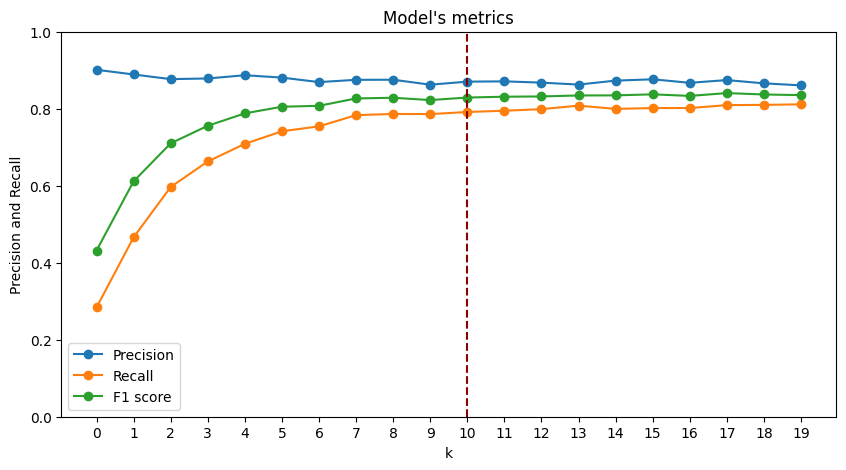

In [78]:
# Get data
c1 = metrics['precision']
c2 = metrics['recall']
c3 = metrics['f1_score']
x = np.arange(len(c1))

# Set up the matplotlib figure
fig, ax1 = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0, 1)
ax1.plot(x, c1, marker = 'o')
ax1.plot(x, c2, marker = 'o')
ax1.plot(x, c3, marker = 'o')
ax1.axvline(x = 10, color = "#8b0000", linestyle = "--")

# Chart setup
plt.title("Model's metrics", fontsize = 12)
plt.xlabel("k", fontsize = 10)
plt.ylabel("Precision and Recall", fontsize = 10)
plt.legend(("Precision", "Recall", "F1 score"), loc = "best")
plt.draw()

In [79]:
from collections import defaultdict
def get_top_n(predictions, n=5):
  
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [80]:
top_n = get_top_n(test_pred, n=5)

In [81]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

ASAE723AV7MYO ['B004M3JTGM', 'B007KYACBQ', 'B003UH4QXC', 'B00957AZPE']
A2I7IS0OXGGVPA ['B009RXU59C', 'B0086TY96S', 'B0093IJR6S', 'B00DMZPQIG', 'B00BRI4W1M']
AWPODHOB4GFWL ['B00EK3UHS8', 'B004X71HXU', 'B00DKCVO7I', 'B002VPE1NO', 'B00B4FG068']
A3DLML1MQIJ302 ['B006J2JJ6E', 'B009HK8TQQ', 'B0092QSQ3Q', 'B00575TN42', 'B0015RB39O']
A10ZFE6YE0UHW8 ['B005VBNYDS', 'B000RYSU7O', 'B00GJYJFKM', 'B0085OB0IE', 'B003WM6SOU']
A3CAVFN5OWP0BS ['B0058J5OXQ', 'B008DJIGR4']
A1PJVW2GSF73E7 ['B000S5Q9CA', 'B004N87OFO', 'B0047KZ1P8', 'B003DQD5CS', 'B00H399HLE']
A18EJ44LWWUO11 ['B00CJRZ31S', 'B00E4LAA56', 'B00APLXD62', 'B00FW1DF0E']
AS8VENYN17UTI ['B00IRBZZJK', 'B00GAVCNZI', 'B00HVJL4Y4', 'B00AANQLRI']
A2DKQQIZ793AV5 ['B00DDLYCUW', 'B00GN6QZ0Y', 'B00GK745L2', 'B00B8M4IMK', 'B00H9HRR1W']
A3HOF3J4OUE8PM ['B005SUHPO6', 'B009RXWJ5K', 'B003RDV0VU', 'B008NFN33U', 'B004FKSF5S']
A1ODOGXEYECQQ8 ['B0073FCPSK', 'B0073F92OK', 'B00C13YSIO', 'B00FAADBHO', 'B00H3IBEGG']
A1OGCPMSIVK7G4 ['B0054ENBBM', 'B007FHX9OK', 'B009HD44US